In [1]:
%matplotlib inline

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms, utils
from torch import optim
from PIL import Image
from imageio import imwrite

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    size = shape if shape is not None else max_size if max(image.size) > max_size else max(image.size) 
    transform = transforms.Compose([transforms.Resize(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    image = transform(image)[:3,:,:].unsqueeze(0).to(device)
    return image    

In [5]:
def image_convert(image):
    image = image.to("cpu").clone().detach().squeeze()
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

In [6]:
# Change the image path to try on custom images
content_path = './images/janelle.png'
style_path = './images/Starry-Night-by-Vincent-Van-Gogh-painting.jpg'

In [7]:
content = load_image(content_path)
style = load_image(style_path, shape=content.shape[-2:])

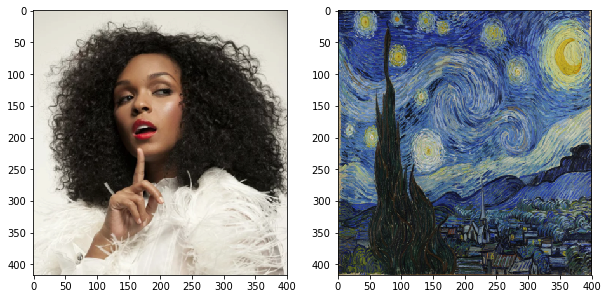

In [8]:
# Displaying the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_convert(content))
ax2.imshow(image_convert(style))

In [9]:
# Selecting features because we don't have any use for the classifier
vgg = models.vgg19(pretrained=True).features
# Turning off gradient updates for the parameters of the model
for parameters in vgg.parameters():
    parameters.requires_grad_(False)
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [10]:
def get_feature_output(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'
                 }
    feature_output = {}
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            feature_output[layers[name]] = image
    return feature_output

In [11]:
def gram_matrix(tensor):
    # batch_size is 1
    batch_size, d, h, w = tensor.shape
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [12]:
# Calculating the feature maps of the layers of interest
content_features = get_feature_output(content, vgg)
style_features = get_feature_output(style, vgg)

# Gram matrix for the style features
style_grams = { layer: gram_matrix(style_features[layer]) for layer in style_features }

# Defining the target image
target = content.clone().requires_grad_(True).to(device)

In [13]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}
content_weight = 1  
style_weight = 1e5
checkpoint = 500
optimizer = optim.Adam([target], lr=0.001)

Total loss:  86012968.0


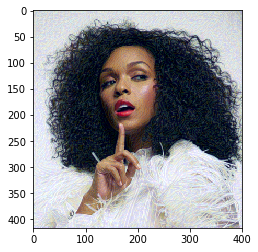

Total loss:  29321546.0


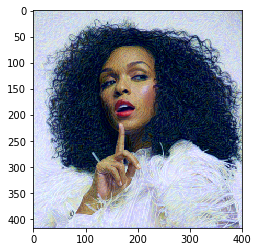

Total loss:  19256460.0


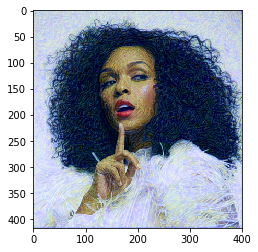

Total loss:  14172350.0


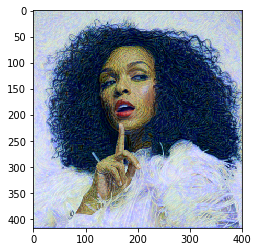

Total loss:  10296145.0


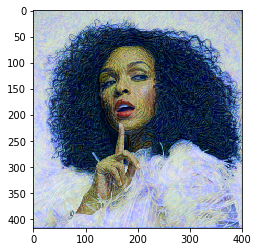

Total loss:  7330360.0


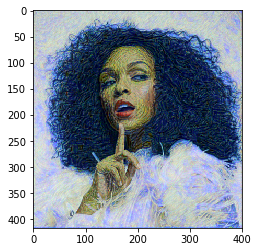

Total loss:  5158751.5


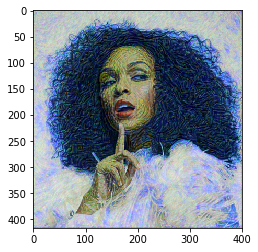

Total loss:  3634104.75


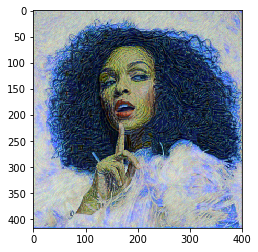

In [14]:

epochs = 4000  

for i in range(epochs):
    
    target_features = get_feature_output(target, vgg)
    
    #Content loss
    content_loss = torch.mean((target_features["conv4_2"]-content_features["conv4_2"])**2)
    
    # Clearing  the accumilated gradients
    optimizer.zero_grad()
    
    # Computing style loss
    style_loss = 0
    for layer in style_weights:
        target_gram = gram_matrix(target_features[layer])
        layer_loss = style_weights[layer]*torch.mean((target_gram-style_grams[layer])**2)
        b, d, h, w = target.shape
        style_loss += layer_loss/(d*h*w)
    
    total_loss = content_weight*content_loss + style_weight*style_loss
    
    # Backpropagation
    total_loss.backward()
    optimizer.step()
    
    # Displaying target image at checkpoints
    if  (i+1) % checkpoint == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(image_convert(target))
        plt.show()

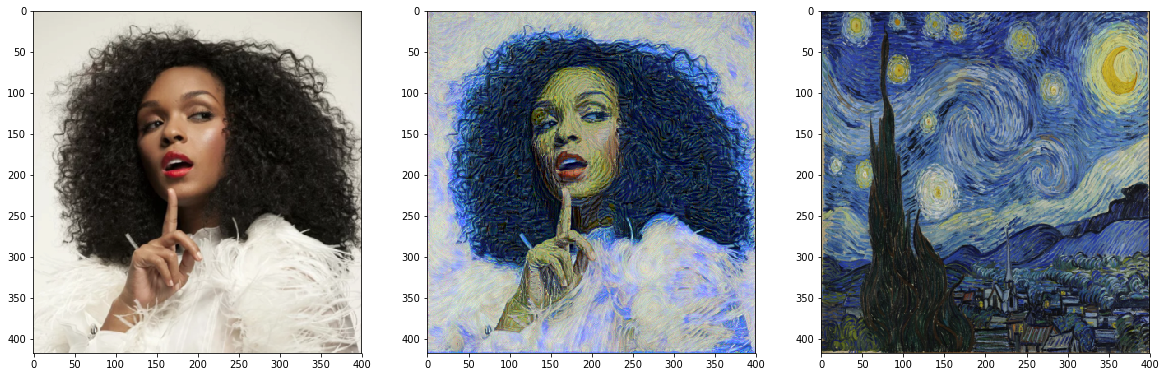

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image_convert(content))
ax2.imshow(image_convert(target))
ax3.imshow(image_convert(style))

In [19]:
# Saving the images
imwrite('./output/content_image.jpg', image_convert(content))
imwrite('./output/target_image.jpg', image_convert(target))
imwrite('./output/style_image.jpg', image_convert(style))